<a href="https://colab.research.google.com/github/urvog/NLP-Sentiment-Analysis/blob/main/NLP_Multiclass_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [365]:
import pandas as pd
import numpy as np
import re, string, spacy
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, Activation, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Dense, Dropout, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import joblib
%matplotlib inline

pd.options.display.max_colwidth = None
np.random.seed(123)

# Importando los datos

In [366]:
!ls data/

df_anger.csv               df_pessimism.csv
df_anticipation.csv        df_sadness.csv
df_disgust.csv             df_surprise.csv
df_fear.csv                df_trust.csv
df_joy.csv                 sem_eval_test_blank_es.csv
df_love.csv                sem_eval_train_es.csv
df_optimism.csv


In [367]:
# Leemos los datos
SENTIMENT_NAME = "trust" #@param
df = pd.read_csv('data/df_'+SENTIMENT_NAME+'.csv', index_col=None)
df.columns = ['Tweet','Sentiment']
df[df.Sentiment>0]

,Tweet,Sentiment
54,"Estoy segura de que en mi examen de hoy saqué 10 y estoy muy contenta, ya quiero hacer otro examen.🙈",1
56,"Necesito personas que digan a todo ""si"" y no que salgan con ""peros""",1
58,"@medicendaysi El martes no hay examen, así que que sea lo que Dios quiera",1
71,"""El único Espada que me resulta ligeramente agradable es Zommari. Me respeta como superior y no perturba mi existencia.""",1
127,@SUR_cultura @cacmalaga @ajavierlopez Pero vamos que es un poco la tesis del cura Perez Pallares de no ofender a nadie.,1
...,...,...
3430,@YazminCantuT Aplausos a la. Suegra,1
3443,Cada una de nosotras tiene un truco para provocar a su pareja,1
3444,Quiero hacer mis propias viñetas y una ilustradora random...soñare en un personaje(: deseadme suerte,1
3518,Orgullosa de ser aquella que tiene problemas y sonrie.,1


# Limpiando los datos


In [368]:
#!python -m spacy download es_core_news_md
import re, string, spacy
nlp=spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation))) #elimina símbolos de puntuación

def clean_text(text, lemas=False):
    """Limpiamos las menciones y URL del texto. Luego convertimos en tokens
    y eliminamos signos de puntuación.
    Si lemas=True extraemos el lema, si no dejamos en minúsculas solamente.
    Como salida volvemos a convertir los tokens en cadena de texto"""
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text) #elimina menciones y URL
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens] #no quitamos stop-words
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

# Preparando los Datos

In [369]:
#limpiamos texto y quitamos tweets que se han quedado vacíos
df.Tweet=df.Tweet.apply(clean_text, lemas=True)
df = df[df['Tweet']!='']

#Enviamos a Y los codigos asignados por label encodr, hay que convertir a numérico para Keras
Y=df.Sentiment

#Separamos entrenamiento y test
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet,Y, test_size = 0.3, random_state = 42)

In [370]:
#Tokenizamos los textos
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(tweets_train.values)

X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')
word_index = tokenizer.word_index
print(f'Número de tokens distintos: {len(word_index)}')
MAX_SEQUENCE_LENGTH = X_train.shape[1]
max_features = len(word_index)+1
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Número de tokens distintos: 5769


In [371]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(2492, 33) (2492,)
(1069, 33) (1069,)


# Preparamos el Modelo

In [372]:
#Creamos el modelo CNN en Keras
#Parámetros de la red
embed_dim = 50
filters = 64
kernel_size = 3

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = MAX_SEQUENCE_LENGTH))
model.add(Dropout(0.2))

# añadimos una capa de convolución 1D que aprende
# filtros de grupos de palabras de tamaño kernel_size
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

# calculamos el max pooling:
model.add(GlobalMaxPooling1D())

# conectamos a una capa de salida de una unidad con activación relu
model.add(Dense(1))
model.add(Activation('sigmoid'))

# compilamos el modelo
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 33, 50)            288500    
                                                                 
 dropout_15 (Dropout)        (None, 33, 50)            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 31, 64)            9664      
                                                                 
 global_max_pooling1d_14 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
 activation_14 (Activation)  (None, 1)                 0         
                                                     

# Entrenamiento

In [373]:
batch_size = 16
history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, verbose=2, validation_data=(X_test, Y_test))

Epoch 1/20


2022-07-08 08:44:42.811516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-08 08:44:45.769126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


156/156 - 4s - loss: 0.2614 - accuracy: 0.9386 - val_loss: 0.2167 - val_accuracy: 0.9439 - 4s/epoch - 23ms/step
Epoch 2/20
156/156 - 1s - loss: 0.1858 - accuracy: 0.9539 - val_loss: 0.2122 - val_accuracy: 0.9439 - 1s/epoch - 9ms/step
Epoch 3/20
156/156 - 1s - loss: 0.1726 - accuracy: 0.9539 - val_loss: 0.2009 - val_accuracy: 0.9476 - 1s/epoch - 9ms/step
Epoch 4/20
156/156 - 1s - loss: 0.1428 - accuracy: 0.9551 - val_loss: 0.2004 - val_accuracy: 0.9467 - 1s/epoch - 8ms/step
Epoch 5/20
156/156 - 1s - loss: 0.0896 - accuracy: 0.9643 - val_loss: 0.2089 - val_accuracy: 0.9429 - 1s/epoch - 8ms/step
Epoch 6/20
156/156 - 1s - loss: 0.0483 - accuracy: 0.9856 - val_loss: 0.2314 - val_accuracy: 0.9401 - 1s/epoch - 8ms/step
Epoch 7/20
156/156 - 1s - loss: 0.0249 - accuracy: 0.9940 - val_loss: 0.2625 - val_accuracy: 0.9439 - 1s/epoch - 8ms/step
Epoch 8/20
156/156 - 1s - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.2825 - val_accuracy: 0.9411 - 1s/epoch - 7ms/step
Epoch 9/20
156/156 - 1s - loss: 0.

# Visualizamos

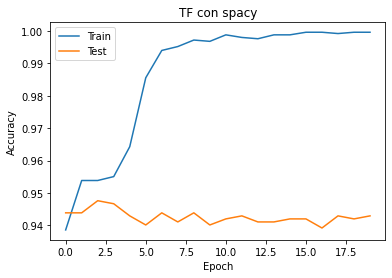

In [387]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('TF con spacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Probamos con algunas inferencias

In [375]:
twt = 'Ya comienza a darme hambre; esa es buena señal'
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences([clean_text(twt, lemas=True)]) #hay que pasar el texto a array
twt = pad_sequences(twt, maxlen=X_train.shape[1], dtype='int32', padding='post', truncating='post', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)
if(np.round(sentiment) == 0):
    print("Desconocido")
elif (np.round(sentiment) == 1):
    print(SENTIMENT_NAME)

1/1 - 0s - 83ms/epoch - 83ms/step
Desconocido


2022-07-08 08:45:09.957712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [376]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

67/67 - 0s - loss: 0.4314 - accuracy: 0.9429 - 193ms/epoch - 3ms/step
score: 0.43
acc: 0.94


In [377]:
X_test.shape

(1069, 33)

In [378]:
predict=model.predict(X_test, batch_size=1)
prediccion=(predict>0.5).tolist()

from sklearn.metrics import classification_report
print(classification_report(Y_test, prediccion, target_names=['N','S']))

1069/1069 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           N       0.95      0.99      0.97      1009
           S       0.46      0.10      0.16        60

    accuracy                           0.94      1069
   macro avg       0.71      0.55      0.57      1069
weighted avg       0.92      0.94      0.93      1069



# Guardamos el Modelo

In [379]:
file_path = "models/"+SENTIMENT_NAME+".jlb"
joblib.dump(model, file_path)

INFO:tensorflow:Assets written to: ram://7bf1d774-0397-4a2e-8b0a-6be748de9e64/assets


INFO:tensorflow:Assets written to: ram://7bf1d774-0397-4a2e-8b0a-6be748de9e64/assets


['models/trust.jlb']

# Predicciones en Dataset de Test

In [380]:
df_eval = pd.read_csv('data/sem_eval_test_blank_es.csv')
df_eval

,ID,Tweet
0,2018-Es-06697,No me pienso perder la pelea de McGregor contra Myweather
1,2018-Es-05385,Yo preocupada pensando que mi papá ya había llegado y me estaba llamando para decirme que el vuelo todavía no había salido 👍
2,2018-Es-03777,Pucha ya no me sirven todos los carros a Rondizzoni.... #ironía jajajjajaja #unañomas
3,2018-Es-02175,"Si estar contigo es un delito, hago cien años en prision 😃"
4,2018-Es-00726,@macacifuentesC @sergmujica Perfect... Y de una mansa ni que terrible PLR
...,...,...
674,2018-Es-06551,@tccharless -Peligro al volante -Tec -Los Santos -Memes -Galletas -3C
675,2018-Es-02782,Vamos a ver q sucedio en mi barrio en los 90 #veronicalapelicula #Vallekas
676,2018-Es-01308,@kopexinfinity FELICIDADES FER 💕 QUE ESTA PASANDO AL AGUS PARA DARLE LIKE A FOTOS DE CARO JAJAAAA
677,2018-Es-02136,"@PabloEmanuel299 LAMENTO MI CONFUSIÓN DE RAMA LEGISLATIVA : Habida cuenta, publicamente corregí. Espero haber satisfecho el reclamo."


In [381]:
#Limpiando los datos 
df_eval.Tweet=df_eval.Tweet.apply(clean_text, lemas=True)
df_eval = df_eval[df_eval['Tweet']!='']
df_eval

,ID,Tweet
0,2018-Es-06697,no yo pensar perder el pelea de mcgregor contra myweather
1,2018-Es-05385,yo preocupado pensar que mi papá ya haber llegar y yo estar llamar para decir yo que el vuelo todavía no haber salir 👍
2,2018-Es-03777,pucha ya no yo servir todo el carro a rondizzoni ironía jajajjajaja unañomas
3,2018-Es-02175,si estar contigo ser uno delito hacer cien año en prision 😃
4,2018-Es-00726,perfect y de uno mansa ni que terrible plr
...,...,...
674,2018-Es-06551,peligro al volante tec los santos memes galleta 3c
675,2018-Es-02782,ir a ver q suceder en mi barrio en el 90 veronicalapelicula vallekas
676,2018-Es-01308,felicidades fer 💕 que este pasando al agus para darle like a foto de caro jajaaaa
677,2018-Es-02136,lamento mi confusión de rama legislativa habida cuenta publicamente corregí esperar haber satisfacer el reclamo


In [382]:
X_test_eval = tokenizer.texts_to_sequences(df_eval.Tweet)
X_test_eval = pad_sequences(X_test_eval, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

In [383]:
X_test_eval

array([[   9,    5,   83, ...,    0,    0,    0],
       [   5,  193,   83, ...,    0,    0,    0],
       [  28,    9,    5, ...,    0,    0,    0],
       ...,
       [ 249,    2,   19, ...,    0,    0,    0],
       [  13,    3,  158, ...,    0,    0,    0],
       [  13, 1846,   24, ...,    0,    0,    0]], dtype=int32)

In [384]:
X_test_eval.shape

(679, 33)

In [385]:
predict_eval = model.predict(X_test_eval, batch_size=1)

679/679 [==============================] - 1s 1ms/step


In [386]:
df_output = pd.DataFrame(df_eval.ID)
df_output[SENTIMENT_NAME] = predict_eval
df_output.to_csv('predictions/pred_'+SENTIMENT_NAME+'.csv', index = False)
df_output


,ID,trust
0,2018-Es-06697,0.000111
1,2018-Es-05385,0.367165
2,2018-Es-03777,0.000181
3,2018-Es-02175,0.001155
4,2018-Es-00726,0.000160
...,...,...
674,2018-Es-06551,0.003706
675,2018-Es-02782,0.001984
676,2018-Es-01308,0.000232
677,2018-Es-02136,0.000511
